#Libraries

In [ ]:
! git clone https://github.com/neuromatch/ComputationThruDynamicsBenchmark
%cd ComputationThruDynamicsBenchmark
! pip install -e .

Cloning into 'ComputationThruDynamicsBenchmark'...
remote: Enumerating objects: 3359, done.
remote: Counting objects: 100% (585/585), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 3359 (delta 519), reused 501 (delta 501), pack-reused 2774 (from 1)
Receiving objects: 100% (3359/3359), 296.08 MiB | 21.72 MiB/s, done.
Resolving deltas: 100% (1883/1883), done.
Updating files: 100% (262/262), done.
/content/ComputationThruDynamicsBenchmark
Obtaining file:///content/ComputationThruDynamicsBenchmark
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.

In [ ]:
!pip uninstall -y torchaudio torchvision

In [ ]:
%cd /content/ComputationThruDynamicsBenchmark/
envStr = """HOME_DIR=/content/ComputationThruDynamicsBenchmark/
# #Don't change these
# TRAIN_INPUT_FILE=train_input.h5\nEVAL_INPUT_FILE=eval_input.h5
# EVAL_TARGET_FILE=eval_target.h5
# """

/content/ComputationThruDynamicsBenchmark


In [ ]:
with open('.env','w') as f:
  f.write(envStr)

In [ ]:
import os
os.chdir('/content/ComputationThruDynamicsBenchmark')
print("Current directory:", os.getcwd())
print("Directory contents:", os.listdir("."))

Current directory: /content/ComputationThruDynamicsBenchmark
Directory contents: ['README.md', '.gitmodules', '.pre-commit-config.yaml', '.git', 'ctd.egg-info', 'examples', '.gitignore', '.env', '.gitattributes', 'ctd', 'requirements.txt', 'pretrained', 'setup.py', 'utils.py', 'libs']


In [ ]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# MotorNet & CTD
from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle
from ctd.task_modeling.task_env.task_env import RandomTarget

#Model

In [ ]:
import motornet as mn
import torch as th
effector = RigidTendonArm26(muscle = MujocoHillMuscle())
env = mn.environment.RandomTargetReach(effector=effector, max_ep_duration=1.)

##Policy Class

In [ ]:
class Policy(th.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, device):
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = 1

        self.gru = th.nn.GRU(input_dim, hidden_dim, 1, batch_first=True)
        self.fc = th.nn.Linear(hidden_dim, output_dim)
        self.sigmoid = th.nn.Sigmoid()

        # the default initialization in torch isn't ideal
        for name, param in self.named_parameters():
            if name == "gru.weight_ih_l0":
                th.nn.init.xavier_uniform_(param)
            elif name == "gru.weight_hh_l0":
                th.nn.init.orthogonal_(param)
            elif name == "gru.bias_ih_l0":
                th.nn.init.zeros_(param)
            elif name == "gru.bias_hh_l0":
                th.nn.init.zeros_(param)
            elif name == "fc.weight":
                th.nn.init.xavier_uniform_(param)
            elif name == "fc.bias":
                th.nn.init.constant_(param, -5.)
            else:
                raise ValueError

        self.to(device)

    def forward(self, x, h0, return_latents=False):
        y, h = self.gru(x[:, None, :], h0)
        u = self.sigmoid(self.fc(y)).squeeze(dim=1)
        if return_latents:
          return u, h, y.squeeze(1)
        return u, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        return hidden

device = th.device("cpu")

policy = Policy(env.observation_space.shape[0], 32, env.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)

##Training

In [ ]:
batch_size = 32
n_batch = 6000
losses = []
interval = 250

def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

for batch in range(n_batch):
  # initialize batch
  h = policy.init_hidden(batch_size=batch_size)
  obs, info = env.reset(options={"batch_size": batch_size})
  terminated = False

  # initial positions and targets
  xy = [info["states"]["fingertip"][:, None, :]]
  tg = [info["goal"][:, None, :]]

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)

    xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
    tg.append(info["goal"][:, None, :])  # targets

  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  tg = th.cat(tg, axis=1)
  loss = l1(xy, tg)  # L1 loss on position

  # backward pass & update weights
  optimizer.zero_grad()
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())

  if (batch % interval == 0) and (batch != 0):
    print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))

Batch 250/6000 Done, mean policy loss: 0.34896294182538984
Batch 500/6000 Done, mean policy loss: 0.1930066990852356
Batch 750/6000 Done, mean policy loss: 0.1544386477470398
Batch 1000/6000 Done, mean policy loss: 0.13316599971055984
Batch 1250/6000 Done, mean policy loss: 0.12219067776203156
Batch 1500/6000 Done, mean policy loss: 0.11340842765569686
Batch 1750/6000 Done, mean policy loss: 0.10648596432805062
Batch 2000/6000 Done, mean policy loss: 0.10425903075933457
Batch 2250/6000 Done, mean policy loss: 0.10044622400403022
Batch 2500/6000 Done, mean policy loss: 0.09667544439435005
Batch 2750/6000 Done, mean policy loss: 0.09487727314233779
Batch 3000/6000 Done, mean policy loss: 0.09168419244885445
Batch 3250/6000 Done, mean policy loss: 0.09020491656661034
Batch 3500/6000 Done, mean policy loss: 0.08948449975252151
Batch 3750/6000 Done, mean policy loss: 0.0875667974948883
Batch 4000/6000 Done, mean policy loss: 0.08487755239009857
Batch 4250/6000 Done, mean policy loss: 0.0842

##Training Loss

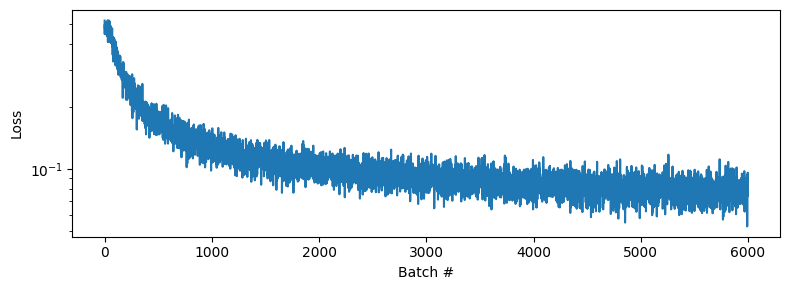

In [ ]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  axs.semilogy(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

##Evaluation

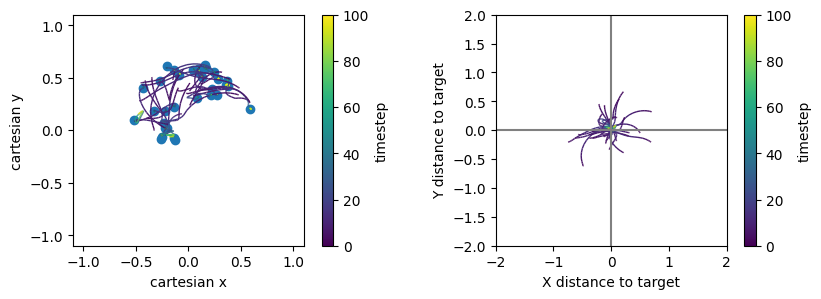

In [ ]:
plotor = mn.plotor.plot_pos_over_time

def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.ylim([-1.1, 1.1])
  plt.xlim([-1.1, 1.1])
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plt.ylim([-2, 2])
  plt.xlim([-2, 2])
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()


plot_simulations(xy=th.detach(xy), target_xy=th.detach(tg))

In [ ]:
import json
import torch as th
weight_file = os.path.join("save", "weights")
log_file = os.path.join("save", "log.json")
cfg_file = os.path.join("save", "cfg.json")

os.makedirs("save", exist_ok=True)
# save model weights
th.save(policy.state_dict(), weight_file)


# save training history (log)
with open(log_file, 'w') as file:
  json.dump(losses, file)


# save environment configuration dictionary
cfg = env.get_save_config()
with open(cfg_file, 'w') as file:
  json.dump(cfg, file)


print("done.")

done.


# Load Model

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving weights to weights
Saving log.json to log.json
Saving cfg.json to cfg.json


In [ ]:
import json
with open("cfg.json", 'r') as file:
    cfg = json.load(file)


for k1, v1 in cfg.items():
  if isinstance(v1, dict):
    print(k1 + ":")
    for k2, v2 in v1.items():
      if type(v2) is dict:
        print("\t\t" + k2 + ":")
        for k3, v3 in v2.items():
          print("\t\t\t\t" + k3 + ": ", v3)
      else:
        print("\t\t" + k2 + ": ", v2)
  else:
    print(k1 + ": ", v1)

name:  Env
T_destination:  ~T_destination
action_frame_stacking:  0
action_noise:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
call_super_init:  False
delay_range:  [0, 0]
device:  cpu
differentiable:  True
dt:  0.01
dump_patches:  False
elapsed:  1.0000000000000007
max_ep_duration:  1.0
metadata:
		render_modes:  []
n_muscles:  6
np_random_seed:  120575145604439455833150564331368486686
nq_init:  None
obs_noise:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
proprioception_delay:  1
proprioception_noise:  [0.0]
q_init:  None
render_mode:  None
seed:  None
space_dim:  2
spec:  None
training:  True
vision_delay:  1
vision_noise:  [0.0]
effector:
		muscle:
				name:  MujocoHillMuscle
				state names:  ['activation', 'muscle length', 'muscle velocity', 'force-length PE', 'force-length CE', 'force-velocity CE', 'force']
		skeleton:
				dof:  2
				dt:  0.01
				space_dim:  2
				I1:  0.051
				I2:  0.057
				L1:  0.309
				L2:  0.333
				L1g:  0.135
				L2g:  0.165
			

In [ ]:
plotor = mn.plotor.plot_pos_over_time

def plot_simulations(xy, target_xy, xlim1=[-1.1, 1.1],xlim2=[-1.1, 1.1]):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(16,6))

  plt.subplot(1,2,1)
  plt.ylim([-1.1, 1.1])
  plt.xlim(xlim1)
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plt.ylim([-1.1, 1.1])
  plt.xlim(xlim2)
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()

##Loaded Model Evaluation

In [ ]:
env2 = mn.environment.RandomTargetReach(effector=RigidTendonArm26(muscle = MujocoHillMuscle()), max_ep_duration=1.)
policy2 = Policy(env.observation_space.shape[0], 32, env.n_muscles, device=device)

policy2.load_state_dict(th.load(weight_file))

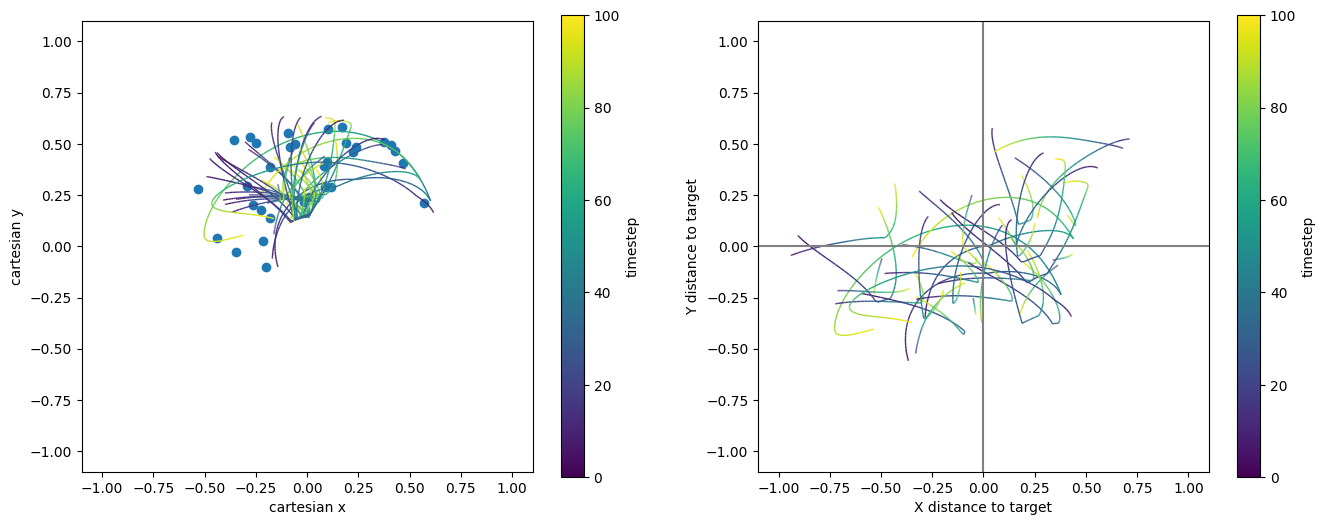

In [ ]:
# initialize batch
batch_size = 32
h = policy.init_hidden(batch_size=batch_size)
obs, info = env.reset(options={"batch_size": batch_size})
terminated = False


# initial positions and targets
xy = [info["states"]["fingertip"][:, None, :]]
tg = [info["goal"][:, None, :]]

# simulate whole episode
while not terminated:  # will run until `max_ep_duration` is reached
  action, h = policy(obs, h)
  obs, reward, terminated, truncated, info = env.step(action=action)

  xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
  tg.append(info["goal"][:, None, :])  # targets

# concatenate into a (batch_size, n_timesteps, xy) tensor
xy = th.detach(th.cat(xy, axis=1))
tg = th.detach(th.cat(tg, axis=1))

plot_simulations(xy=xy, target_xy=tg)

# 1N Left Force-Field

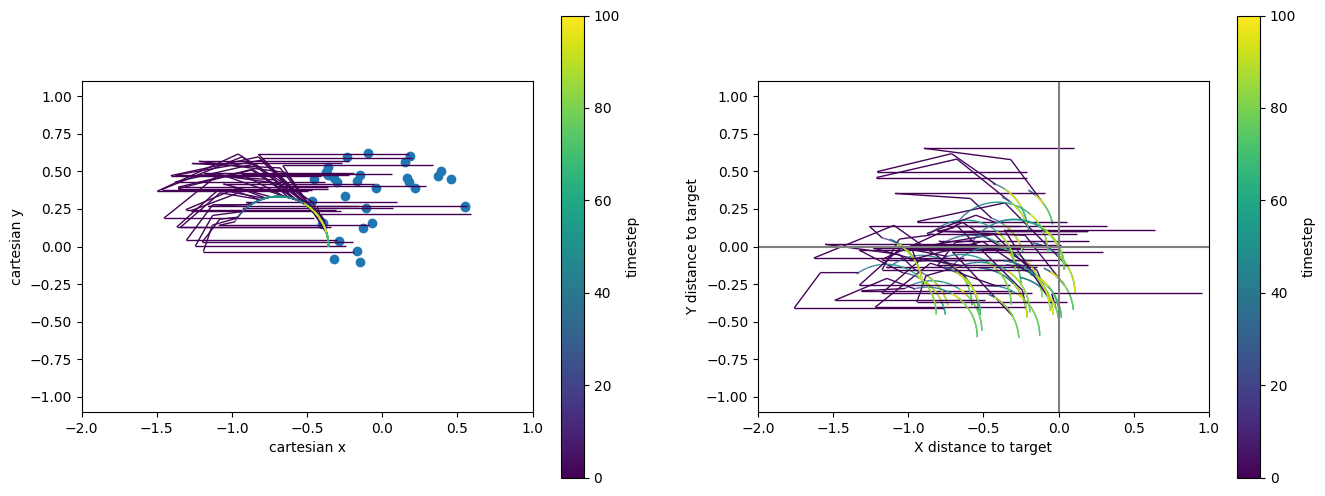

In [ ]:
force = th.tensor([-1.0, 0.0], dtype=th.float32)  # Leftward 1N force
scale = 1 #can change based on the time step

# initialize batch, position and targets
h = policy.init_hidden(batch_size=batch_size)
obs, info = env.reset(options={"batch_size": batch_size})
terminated = False
xy = [info["states"]["fingertip"][:, None, :]]
tg = [info["goal"][:, None, :]]

# simulate whole episode
while not terminated:
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)

    # Apply force to fingertip and joint (simulate displacement)
    fingertip_force = force.to(info["states"]["fingertip"].device) * scale
    info["states"]["fingertip"] = info["states"]["fingertip"].clone() + fingertip_force

    # Only apply to x and y of joint (assumes joint[:, :2] are positions)
    joint_force = force.to(info["states"]["joint"].device) * scale
    info["states"]["joint"] = info["states"]["joint"].clone()
    info["states"]["joint"][:, :2] += joint_force

    xy.append(info["states"]["fingertip"][:, None, :])
    tg.append(info["goal"][:, None, :])

xy = th.detach(th.cat(xy, axis=1))
tg = th.detach(th.cat(tg, axis=1))

plot_simulations(xy=xy, target_xy=tg, xlim1=[-2, 1],xlim2=[-2, 1])

# Visualization - Q6

In [ ]:
def simulate_latents(policy, env, device, n_trials=64, max_steps=100):
    policy.eval()
    latent_list = []

    for trial in range(n_trials):
        h = policy.init_hidden(batch_size=1)
        obs, info = env.reset(options={"batch_size": 1})
        trial_latents = []

        for t in range(max_steps):
            with th.no_grad():
                _, h, latent = policy(obs, h, return_latents=True)
                trial_latents.append(latent.cpu().numpy())  # shape: [1, hidden_dim]
                obs, reward, terminated, truncated, info = env.step(action=policy.fc(latent).sigmoid())
                if terminated:
                    break

        # Pad short episodes to max_steps
        while len(trial_latents) < max_steps:
            trial_latents.append(np.zeros_like(trial_latents[-1]))

        latent_list.append(np.stack(trial_latents, axis=0))  # shape: [time, dim]

    # Final shape: [trials, time, latent_dim]
    return np.stack(latent_list, axis=0)

In [62]:
def plot_latent_dynamics(latents, model_name="PolicyModel"):
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    trial_length = latents.shape[1]
    target_onset_time = int(0.1 * trial_length)
    go_cue_time = int(0.3 * trial_length)
    print("latents.shape =", latents.shape)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Time-Aligned Latent Activity: {model_name}', fontsize=14)

    # Plot 1: Mean latent activity
    ax1 = axes[0, 0]
    # Remove singleton dimension if needed
    if latents.shape[2] == 1:
        latents = latents.squeeze(axis=2)  # (64, 100, 32)
    mean_activity = np.mean(latents, axis=(0, 2))  # → shape: (timesteps,)
    std_activity = np.std(latents, axis=(0, 2))    # → shape: (timesteps,)
    time_axis = np.arange(trial_length)
    print("mean_activity shape:", mean_activity.shape)
    print("std_activity shape:", std_activity.shape)

    ax1.plot(time_axis, mean_activity, 'b-', linewidth=2)
    ax1.fill_between(time_axis, mean_activity - std_activity, mean_activity + std_activity, alpha=0.3)
    ax1.axvline(target_onset_time, color='red', linestyle='--', label='Target Onset')
    ax1.axvline(go_cue_time, color='green', linestyle='--', label='Go Cue')
    ax1.set_title('Mean Latent Activity Over Time')
    ax1.set_xlabel('Time (steps)')
    ax1.set_ylabel('Mean Activity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: PCA
    ax2 = axes[0, 1]
    flat_latents = latents.reshape(-1, latents.shape[-1])
    pca = PCA(n_components=3)
    latents_pca = pca.fit_transform(flat_latents)
    latents_pca_trials = latents_pca.reshape(latents.shape[0], trial_length, -1)

    for pc in range(3):
        pc_mean = np.mean(latents_pca_trials[:, :, pc], axis=0)
        ax2.plot(time_axis, pc_mean, label=f'PC{pc+1} ({pca.explained_variance_ratio_[pc]:.2%})')
    ax2.axvline(target_onset_time, color='red', linestyle='--')
    ax2.axvline(go_cue_time, color='green', linestyle='--')
    ax2.set_title('Principal Component Activity')
    ax2.set_xlabel('Time (steps)')
    ax2.set_ylabel('PC Activity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Target encoding
    ax3 = axes[1, 0]
    onset_window = 10
    pre = np.mean(latents[:, target_onset_time - onset_window:target_onset_time, :], axis=1)
    post = np.mean(latents[:, target_onset_time:target_onset_time + onset_window, :], axis=1)
    diff = np.mean(np.abs(post - pre), axis=0)
    ax3.bar(np.arange(len(diff)), diff)
    ax3.set_title("Target Encoding: Activity Change at Onset")
    ax3.set_xlabel("Latent Dimension")
    ax3.set_ylabel("Mean Absolute Change")
    ax3.grid(True, alpha=0.3)

    # Plot 4: Go cue encoding
    ax4 = axes[1, 1]
    pre = np.mean(latents[:, go_cue_time - onset_window:go_cue_time, :], axis=1)
    post = np.mean(latents[:, go_cue_time:go_cue_time + onset_window, :], axis=1)
    diff = np.mean(np.abs(post - pre), axis=0)
    ax4.bar(np.arange(len(diff)), diff, color='green')
    ax4.set_title("Go Cue Response: Activity Change")
    ax4.set_xlabel("Latent Dimension")
    ax4.set_ylabel("Mean Absolute Change")
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

latents.shape = (64, 100, 1, 32)
mean_activity shape: (100,)
std_activity shape: (100,)


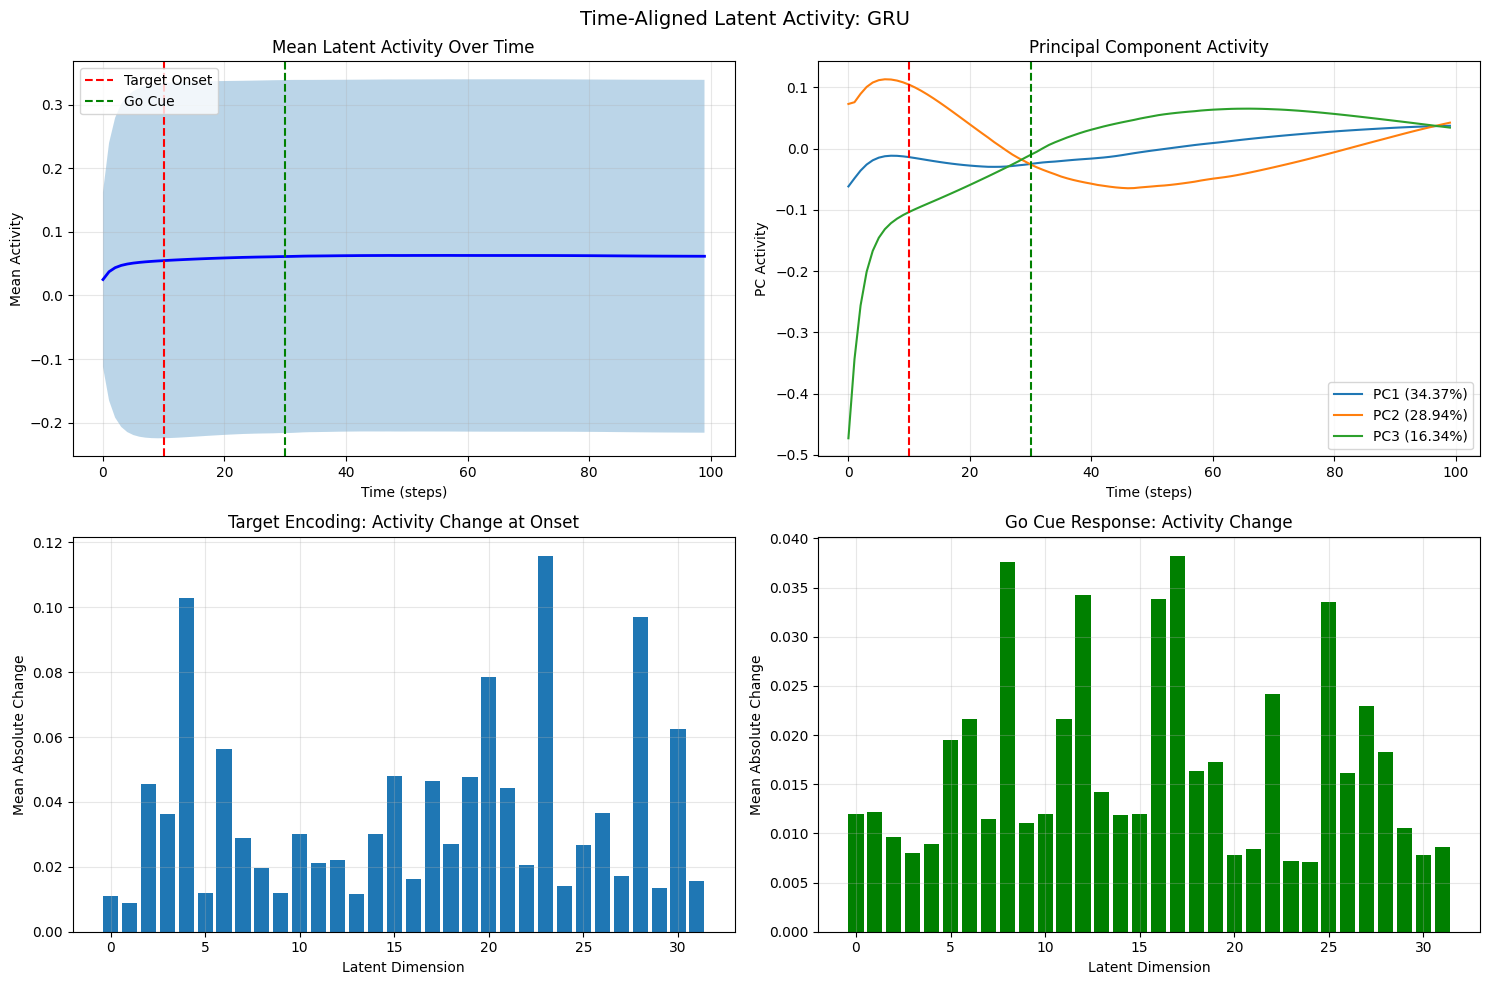

In [64]:
latents = simulate_latents(policy, env, device=device, n_trials=64, max_steps=100)
plot_latent_dynamics(latents, model_name="GRU")